In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random_data_analysis import get_path_lengths_for_all_users, decisions_to_subject_decisions
from data_parser import convert_data, get_csv

In [2]:
df = pd.read_csv('data/current_model_prefs.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,subject,preferred_model,evaluation,parameters
0,0e9aebe0-7972-11ed-9421-5535258a0716,Combined_Memory,-0.437731,"[0.0, 1.5, 0.75, 0.1, 10.0]"
1,14914210-7972-11ed-a3bb-674c56c9a5f7,Combined_Memory,-0.449267,"[0.0, 1.0, 0.5, 0.1, 10.0]"
2,1af65fa0-7972-11ed-8e76-65fbafc77b31,Steps_Cells,-0.475267,"[2.0, 10.0]"
3,1c5fb3a0-7972-11ed-92f5-192da827d727,Probability_Weighted,-0.459824,"[1.0, 1.25, 10.0]"
4,1ed4f960-7972-11ed-abfe-53a0662f3357,Random,-0.484267,"[0.0, 10.0]"


In [3]:
# get fraction of subjects who prefer each model
bar_chart_data = {}
for model in ['Combined_Memory', 'Combined_No_Memory', 'Steps_Cells', 'Discounted_Utility', 'Probability_Weighted', 'Expected_Utility', 'Random']:
    bar_chart_data[model] = df[df['preferred_model'] == model]['subject'].nunique()/df['subject'].nunique()

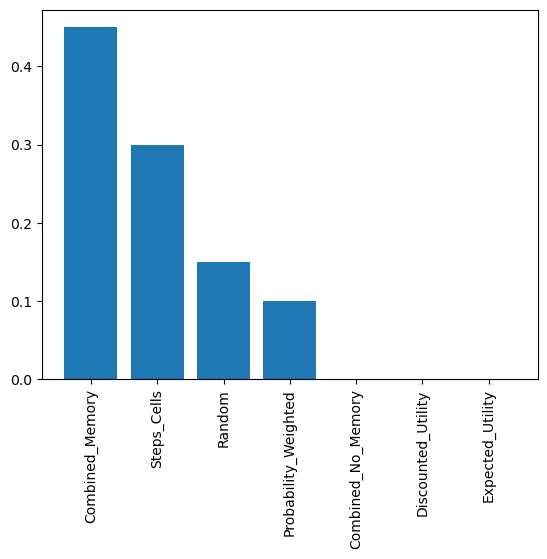

In [4]:
# plot bar chart in sorted order
sorted_keys = sorted(bar_chart_data, key=bar_chart_data.get, reverse=True)
sorted_values = [bar_chart_data[key] for key in sorted_keys]
plt.bar(sorted_keys, sorted_values)
plt.xticks(rotation='vertical')
plt.show()

### Parameters

In [5]:
import numpy as np

param order for combined memory: discount factor, bad estimation factor, memory weight, learning rate

Note: tau (the softmax parameter) is fixed at 10

In [6]:
# calculate the median best parameters for each model
median_params = {}
for model in ['Combined_Memory', 'Steps_Cells', 'Probability_Weighted', 'Random']:
    params = df[df['preferred_model'] == model]['parameters']
    for param in params:
        if model not in median_params:
            median_params[model] = [[] for i in range(len(eval(param)))]
        for i, val in enumerate(eval(param)):
            median_params[model][i].append(val)
    median_params[model] = [np.median(vals) for vals in median_params[model]]
print(median_params)

{'Combined_Memory': [0.0, 1.5, 0.5, 0.1, 10.0], 'Steps_Cells': [1.5, 10.0], 'Probability_Weighted': [1.0, 0.75, 10.0], 'Random': [0.0, 10.0]}


## Humans + Models

### Humans

In [7]:
# get total steps taken by each subject
decisions = convert_data(get_csv('data/prolific_data_filtered'))
path_lengths_by_user = get_path_lengths_for_all_users(decisions)
total_path_length_per_user = []
for tester_id in path_lengths_by_user:
    total_path_length_per_user.append(sum(path_lengths_by_user[tester_id]))

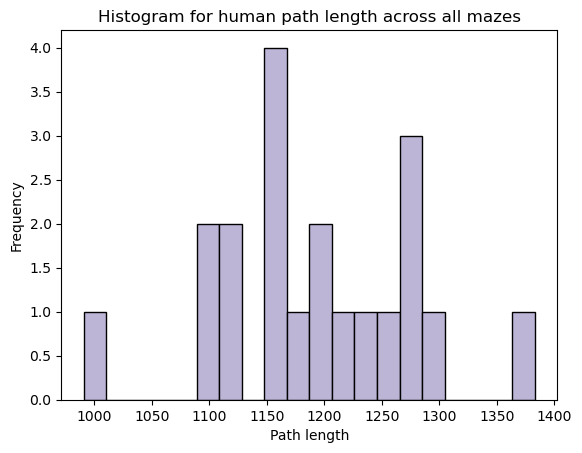

In [8]:
# plot avg total path length for each user and for each model
plt.hist(total_path_length_per_user, bins=20, histtype = 'bar', edgecolor='black', color='#BDB5D5')
plt.ylabel('Frequency')
plt.xlabel('Path length')
plt.title('Histogram for human path length across all mazes')
plt.show()

### Correlations

In [9]:
from decisionmodel import DecisionModel, blind_nodevalue_comb, blind_nodevalue_with_memory, softmax_complement, random_heuristic, steps_cells_heuristic
from avg_log_likelihood import avg_log_likelihood_decisions
from test_mazes import mazes
from scipy.stats import pearsonr

In [10]:
# calculate human choice probabilities
subject_decisions = decisions_to_subject_decisions(decisions)
human_choice_probs = {}
for subject in subject_decisions:
    for decision in subject_decisions[subject]:
        if decision[0] in human_choice_probs:
            if decision[1] in human_choice_probs[decision[0]]:
                human_choice_probs[decision[0]][decision[1]] += 1
            else:
                human_choice_probs[decision[0]][decision[1]] = 1
        else:
            human_choice_probs[decision[0]] = {}
            human_choice_probs[decision[0]][decision[1]] = 1
for maze in human_choice_probs:
    total = sum(human_choice_probs[maze].values())
    for choice in human_choice_probs[maze]:
        human_choice_probs[maze][choice] /= total


In [11]:
expected_utility_model = DecisionModel('Expected_Utility', parent_params=(10,), node_params=(1,1), raw_nodevalue_func=blind_nodevalue_comb, parent_nodeprob_func=softmax_complement)
discounted_utility_model = DecisionModel('Discounted_Utility', parent_params=(10,), node_params=(.5,1), raw_nodevalue_func=blind_nodevalue_comb, parent_nodeprob_func=softmax_complement)
random_model = DecisionModel('Random', parent_params=(10,), node_params=(None,), raw_nodevalue_func=random_heuristic, parent_nodeprob_func=softmax_complement)
probability_weighted_utility_model = DecisionModel('Probability_Weighted', parent_params=(10,), node_params=(1,.75), raw_nodevalue_func=blind_nodevalue_comb, parent_nodeprob_func=softmax_complement)
steps_cells_heuristic_model = DecisionModel('Steps_Cells', parent_params=(10,), node_params=(1.5,), raw_nodevalue_func=steps_cells_heuristic, parent_nodeprob_func=softmax_complement)
combined_no_memory_model = DecisionModel('Combined_No_Memory', parent_params=(10,), node_params=(0,1.5), raw_nodevalue_func=blind_nodevalue_comb, parent_nodeprob_func=softmax_complement)
combined_memory_model = DecisionModel('Combined_Memory', parent_params=(10,), node_params=(0,1.5,0.5,.1), raw_nodevalue_func=blind_nodevalue_with_memory, parent_nodeprob_func=softmax_complement)
models = [expected_utility_model, discounted_utility_model, random_model, probability_weighted_utility_model, steps_cells_heuristic_model, combined_no_memory_model, combined_memory_model]

In [12]:
human_decision_to_prob = {(maze, choice): prob for maze in human_choice_probs for choice, prob in human_choice_probs[maze].items()}

In [13]:
import math
def compute_correlation(human_choice_probs, model_choice_probs):
    correlations = []
    x = []
    y = []
    for maze_object, human_probs in human_choice_probs.items():
        model_probs = model_choice_probs[maze_object]
        # Make sure that the human and model choice probabilities are for the same children
        # assert set(human_probs.keys()) == set(model_probs.keys())
        # Convert the dictionaries of choice probabilities to lists
        human_probs_list = [human_probs[child] for child in human_probs]
        model_probs_list = [model_probs[child] for child in human_probs]
        x.extend(human_probs_list)
        y.extend(model_probs_list)
        # print(len(human_probs_list), len(model_probs_list))
        # Compute the Pearson correlation coefficient
        if len(human_probs_list) > 1:
            r, _ = pearsonr(human_probs_list, model_probs_list)
            if math.isnan(r):
                correlations.append(0)
            else:
                correlations.append(r)
        else:
            correlations.append(1)
    return correlations


# calculate the correlation between human choice probabilities and model choice probabilities for each model
result = {}
mazes_list = [mazes[maze_name] for maze_name in mazes]

for model in models:
    choice_probs_list = model.choice_probs(mazes_list)
    all_model_choice_probs = {}
    for cp in model.choice_probs(mazes_list):
        all_model_choice_probs.update(cp)
    correlations = compute_correlation(human_choice_probs, all_model_choice_probs)
    avg_correlation = sum(correlations) / len(correlations)
    result[model.model_name] = avg_correlation

print(result)

/Users/nabilbaugher/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'Expected_Utility': 0.8308693056605208, 'Discounted_Utility': 0.8073210674285807, 'Random': 0.7974949140163685, 'Probability_Weighted': 0.8199021019841274, 'Steps_Cells': 0.8144606723213286, 'Combined_No_Memory': 0.7981829454514996, 'Combined_Memory': 0.8562451522999887}


In [15]:
from collections import deque
def distance_to_exit(maze, point1, point2):
    """
    Get the distance from point to point using bfs.
    """
    non_walls = set(maze.black) | set(maze.path) | set([maze.exit]) | set([maze.start])
    q = deque() # (row, col, distance)
    q.append((point1[0], point1[1], 0))
    while q:
        row, col, distance = q.popleft()
        if (row, col) == point2:
            return distance
        if (row, col) not in non_walls:
            continue
        non_walls.remove((row, col))
        q.append((row + 1, col, distance + 1))
        q.append((row - 1, col, distance + 1))
        q.append((row, col + 1, distance + 1))
        q.append((row, col - 1, distance + 1))
    return float('inf')   

# calculate expected total path length for each model
def calculate_path_length_probs(maze_object, model_choice_probs, path_length_probs, current_length, current_prob=1, exited=False):
    # Check if the current maze object is the exit
    if exited:
        # Update the probability of the current path length if the current maze object is the exit
        path_length_probs[current_length] = path_length_probs.get(current_length, 0) + current_prob
        # if path_length_probs.get(current_length, 0) + current_prob > 1:
        #     print(path_length_probs.get(current_length, 0) + current_prob)
    else:
        if maze_object.exit is None:
            exited = True
        # Get the choice probabilities for the current maze object
        probs = model_choice_probs[maze_object]
        # Recursively visit the children of the current maze object
        for child, prob in probs.items():
            calculate_path_length_probs(child, model_choice_probs, path_length_probs, current_length + distance_to_exit(maze_object, maze_object.pos, child.pos), current_prob * prob, exited)
    return path_length_probs

# Initialize a dictionary to store the probability of each path length
# path_length_probs = {}
# Start the recursive function at the starting maze object
model_to_path_length_probs = {model.model_name: [] for model in models}
for model in models:
    for maze in mazes_list:
        print(model.model_name, maze.name)
        path_length_probs = {}
        choice_probs_list = model.choice_probs(mazes_list)
        all_model_choice_probs = {}
        for cp in model.choice_probs(mazes_list):
            all_model_choice_probs.update(cp)
        result = calculate_path_length_probs(maze, all_model_choice_probs, path_length_probs, 0)
        model_to_path_length_probs[model.model_name].append(result)

Expected_Utility 1
Expected_Utility 2
Expected_Utility 3
Expected_Utility 4
Expected_Utility 5
Expected_Utility 6
Expected_Utility 7
Expected_Utility 8
Expected_Utility 9
Expected_Utility 10
Expected_Utility 11
Expected_Utility 12
Expected_Utility 13
Expected_Utility 14
Expected_Utility 15
Expected_Utility 16
Expected_Utility 17
Expected_Utility 18
Expected_Utility 19
Expected_Utility 20
Expected_Utility 21
Expected_Utility 22
Expected_Utility 23
Expected_Utility 24
Expected_Utility 25
Expected_Utility 26
Expected_Utility 27
Expected_Utility 28
Expected_Utility 29
Expected_Utility 30
Discounted_Utility 1
Discounted_Utility 2
Discounted_Utility 3
Discounted_Utility 4
Discounted_Utility 5
Discounted_Utility 6
Discounted_Utility 7
Discounted_Utility 8
Discounted_Utility 9
Discounted_Utility 10
Discounted_Utility 11
Discounted_Utility 12
Discounted_Utility 13
Discounted_Utility 14
Discounted_Utility 15
Discounted_Utility 16
Discounted_Utility 17
Discounted_Utility 18
Discounted_Utility 19


In [21]:
def get_combinations(path_length_probs_list):
    # initialize the combinations dictionary with the first maze's path length probabilities
    combinations = path_length_probs_list[0]
    # iterate over the rest of the mazes
    for i in range(1, len(path_length_probs_list)):
        # get the path length probabilities for the current maze
        probs = path_length_probs_list[i]
        # create a temporary dictionary to store the updated combinations
        temp = {}
        # iterate over the combinations and probs dictionaries
        for path_length1, prob1 in combinations.items():
            for path_length2, prob2 in probs.items():
                # add the path lengths and update the probability
                total_length = path_length1 + path_length2
                total_prob = prob1 * prob2
                if total_length in temp:
                    temp[total_length] += total_prob
                else:
                    temp[total_length] = total_prob
        # update the combinations dictionary with the new values
        combinations = temp
    return combinations
# calculate the probability of each overall path length for each model
combinations = {}
for model in models:
    print(model.model_name)
    path_length_probs_list = model_to_path_length_probs[model.model_name]
    combinations[model.model_name] = get_combinations(path_length_probs_list)


Expected_Utility
Discounted_Utility
Random
Probability_Weighted
Steps_Cells
Combined_No_Memory
Combined_Memory


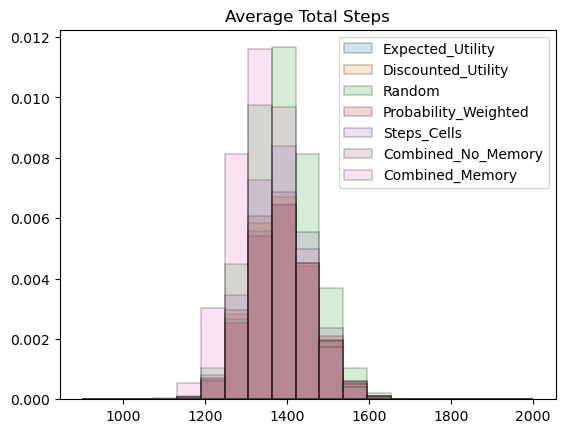

In [47]:
# histogram: probability of each overall path length for each model
import collections
bins = np.linspace(900, 2000, 20)
for model in models:
    plt.hist(combinations[model.model_name].keys(), weights=combinations[model.model_name].values(), bins=bins, alpha=0.2, label=model.model_name, edgecolor='black', linewidth=1.2)
# add human data to the histogram
human_path_lengths = collections.Counter(total_path_length_per_user)
human_path_lengths = {k: v / len(total_path_length_per_user) for k, v in human_path_lengths.items()}
# plt.hist(human_path_lengths.keys(), weights=human_path_lengths.values(), bins=bins, alpha=0.2, label='Human', edgecolor='black', linewidth=1.2)
plt.title('Average Total Steps')
plt.legend()

In [34]:
# import csv
# # save combinations to csv
# with open('combinations.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerow(['model', 'path_length', 'probability'])
#     for model in models:
#         for path_length, prob in combinations[model.model_name].items():
#             writer.writerow([model.model_name, path_length, prob])